In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import tensorflow.keras.layers as layers
from sklearn.model_selection import KFold
import scipy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval


In [2]:
BATCH_SIZE = 256
FIG_SIZE = (16, 10)

In [3]:
df = pd.read_pickle('train1.pkl')
df

,AvgP1,AvgT,AvgH,AvgP2,AvgP3,DateTime,holidays,dayofweek
DateTime,,,,,,,,
2017-02-06 00:00:00,0.0,3.500000,98.599998,0.0,0.0,2017-02-06 00:00:00,0,0
2017-02-06 17:00:00,81.0,9.500000,84.599998,80.0,69.0,2017-02-06 17:00:00,0,0
2017-02-06 17:15:00,0.0,9.200000,86.800003,0.0,0.0,2017-02-06 17:15:00,0,0
2017-02-06 17:30:00,86.0,8.700000,87.900002,0.0,0.0,2017-02-06 17:30:00,0,0
2017-02-06 17:45:00,0.0,7.650000,89.849998,82.0,0.0,2017-02-06 17:45:00,0,0
...,...,...,...,...,...,...,...,...
2019-04-10 14:30:00,82.0,15.700000,65.500000,81.0,-22.0,2019-04-10 14:30:00,0,2
2019-04-10 14:45:00,71.0,16.900000,62.349998,71.0,6.0,2019-04-10 14:45:00,0,2
2019-04-10 15:00:00,71.0,17.400000,57.900002,70.0,29.0,2019-04-10 15:00:00,0,2


In [4]:
def get_windows(x, win_in=100, win_out=64):
    y = np.vstack([x[i+win_in:i+win_in+win_out] for i in range(len(x)-win_in-win_out)])
    x = np.vstack([x[i:i+win_in] for i in range(len(x)-win_in-win_out)])
    return x, y
def holidays_score(x, win_in=100, win_out=64):
    return np.vstack([np.mean(x[i+win_in:i+win_in+win_out]) > 0.5 for i in range(len(x)-win_in-win_out)]).astype('int8')
def normalize(x, mi, sigma):
    return (x.copy()-mi) / sigma

In [11]:
def get_model(units=[64, 32, 16, 8, 4], dropout_rate=0.1, layernorm=True, inp_noise=0.0, inp_dropout=0.0, loss='mse', recurrent='gru'):
    inp = layers.Input(shape=(None, 1))
    x = inp
    
    recurrent_layer = {
        'gru': layers.GRU,
        'lstm': layers.LSTM,
        'rnn': layers.SimpleRNN,
    }[recurrent]
    
    x = tf.keras.layers.GaussianNoise(inp_noise)(x)
    x = tf.keras.layers.Dropout(inp_dropout)(x)
    
        
    for unit in units:
        x = layers.Bidirectional(recurrent_layer(unit, return_sequences=True))(x)
        if layernorm:
            x = layers.LayerNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        
    x = recurrent_layer(1, return_sequences=True)(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    
    opt = tf.keras.optimizers.Adam(1e-3)
    
    loss = PrefixParse(
        {'mse':tf.losses.MSE,
         'mae':tf.losses.MAE,
         'robust':tfa.losses.pinball_loss
        }[loss])
    
    model.compile(opt, loss, metrics=[PrefixParse(tf.keras.metrics.MSE, name='mse'),
                                      PrefixParse(tf.keras.metrics.MAPE, name='mape'),
                                      PrefixParse(tf.keras.metrics.MAE, name='mae')])
    return model


def PrefixParse(funct, name=None, **karg):
    @tf.function
    def f(y_true, y_pred):
        win_out = y_true.shape[1]
        y_pred = y_pred[:,-win_out:,:]
        return funct(y_pred, y_true, **karg)
    if name is None:
        name = funct.__name__
    f.__name__ = name
    return f

In [6]:
x, y = get_windows(df['AvgP2'])

In [7]:
x = np.expand_dims(x, axis=-1)
y = np.expand_dims(y, axis=-1)
x.shape, y.shape

((76160, 100, 1), (76160, 64, 1))

In [8]:
factor = int(0.7 * len(x))
x, x_test = np.split(x, [factor])
y, y_test = np.split(y, [factor])
x.shape, y.shape, x_test.shape, y_test.shape

((53312, 100, 1), (53312, 64, 1), (22848, 100, 1), (22848, 64, 1))

In [9]:
holidays = holidays_score(df['holidays'])
holidays, holidays_test = np.split(holidays, [factor])
holidays.shape, holidays_test.shape

((53312, 1), (22848, 1))

In [12]:
def parse_params(params):
    params['units'] = []
    for i in range(4):
        if i < params['n_layers']:
            params['units'].append(int(params[f'unit_{i}']))
        del params[f'unit_{i}']
    del params['n_layers']
    return params

def objective(params):
    kf = KFold(n_splits=5)
    ans = {}
    params = parse_params(params)

    
    
    for idx, (train_index, val_index) in enumerate(kf.split(x)):
        model = get_model(**params)
        mi = np.mean(x[train_index])
        sigma = np.std(x[train_index])
        x_train = normalize(x[train_index], mi, sigma)
        y_train = normalize(y[train_index], mi, sigma)
        x_val = normalize(x[val_index], mi, sigma)
        y_val = normalize(y[val_index], mi, sigma)
        
        hist = model.fit(x_train, y_train,
                 batch_size=BATCH_SIZE,
                 epochs=100,
                 validation_data=(x_val, y_val),
                 verbose=2,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)]).history
        
        print(params, min(hist['val_mse']))
        return min(hist['val_mse'])
        
space = {'n_layers':hp.quniform('n_layers', 0, 4, 1),
         'unit_0':hp.quniform('unit_0', 4, 128, 1),
         'unit_1':hp.quniform('unit_1', 4, 128, 1),
         'unit_2':hp.quniform('unit_2', 4, 128, 1),
         'unit_3':hp.quniform('unit_3', 4, 128, 1),
         'dropout_rate':hp.uniform('dropout_rate', 0.0, 0.5), 
         'layernorm':hp.choice('layernorm', [False, True]), 
         'inp_noise':hp.uniform('inp_noise', 0.0, 0.5),
         'inp_dropout':hp.uniform('inp_dropout', 0.0, 0.5),
         'loss':hp.choice('loss', ['mse', 'mae', 'robust']),
         'recurrent':hp.choice('recurrent', ['gru', 'lstm', 'rnn']),
}
best = fmin(objective, space, algo=tpe.suggest, max_evals=40)
best

Epoch 1/100                                                                                                            
167/167 - 11s - loss: 0.2592 - mse: 0.6149 - mape: 499.5863 - mae: 0.5184 - val_loss: 0.3017 - val_mse: 0.7132 - val_mape: 1313.0148 - val_mae: 0.6034

Epoch 2/100                                                                                                            
167/167 - 9s - loss: 0.2224 - mse: 0.4997 - mape: 318.5310 - mae: 0.4448 - val_loss: 0.2929 - val_mse: 0.6917 - val_mape: 390.0491 - val_mae: 0.5858

Epoch 3/100                                                                                                            
167/167 - 9s - loss: 0.2172 - mse: 0.4843 - mape: 357.2964 - mae: 0.4344 - val_loss: 0.2942 - val_mse: 0.6925 - val_mape: 443.2272 - val_mae: 0.5883

Epoch 4/100                                                                                                            
167/167 - 9s - loss: 0.2145 - mse: 0.4763 - mape: 234.5145 - mae: 0.

Epoch 6/100                                                                                                            
167/167 - 22s - loss: 0.3949 - mse: 0.4200 - mape: 323.9440 - mae: 0.3949 - val_loss: 0.5645 - val_mse: 0.6210 - val_mape: 473.0172 - val_mae: 0.5645

Epoch 7/100                                                                                                            
167/167 - 22s - loss: 0.3892 - mse: 0.4131 - mape: 245.1828 - mae: 0.3892 - val_loss: 0.5876 - val_mse: 0.6629 - val_mape: 956.7283 - val_mae: 0.5876

Epoch 8/100                                                                                                            
167/167 - 22s - loss: 0.3859 - mse: 0.4075 - mape: 275.5214 - mae: 0.3859 - val_loss: 0.5857 - val_mse: 0.6231 - val_mape: 1037.8000 - val_mae: 0.5857

{'dropout_rate': 0.1952281655961277, 'inp_dropout': 0.2919064903558581, 'inp_noise': 0.21920236286239486, 'layernorm': True, 'loss': 'mae', 'recurrent': 'gru', 'units': [66, 107, 30]}
0.

167/167 - 19s - loss: 0.5985 - mse: 0.5985 - mape: 875.4418 - mae: 0.5503 - val_loss: 0.7748 - val_mse: 0.7748 - val_mape: 479.6467 - val_mae: 0.6608

Epoch 2/100                                                                                                            
167/167 - 17s - loss: 0.4994 - mse: 0.4994 - mape: 613.4582 - mae: 0.4925 - val_loss: 0.7083 - val_mse: 0.7083 - val_mape: 674.4898 - val_mae: 0.6236

Epoch 3/100                                                                                                            
167/167 - 17s - loss: 0.4426 - mse: 0.4426 - mape: 465.5895 - mae: 0.4520 - val_loss: 0.6332 - val_mse: 0.6332 - val_mape: 676.3046 - val_mae: 0.5847

Epoch 4/100                                                                                                            
167/167 - 17s - loss: 0.4158 - mse: 0.4158 - mape: 433.6501 - mae: 0.4309 - val_loss: 0.6317 - val_mse: 0.6317 - val_mape: 506.4969 - val_mae: 0.5669

Epoch 5/100                         

{'dropout_rate': 0.38554873432558606, 'inp_dropout': 0.32036472520290643, 'inp_noise': 0.4735539188867286, 'layernorm': True, 'loss': 'robust', 'recurrent': 'lstm', 'units': [118, 58, 125]}
0.6441891193389893                                                                                                     
Epoch 1/100                                                                                                            
167/167 - 31s - loss: 0.3154 - mse: 0.8022 - mape: 241.7751 - mae: 0.6307 - val_loss: 0.3584 - val_mse: 0.9489 - val_mape: 124.0339 - val_mae: 0.7169

Epoch 2/100                                                                                                            
167/167 - 30s - loss: 0.2774 - mse: 0.6483 - mape: 248.3493 - mae: 0.5549 - val_loss: 0.3298 - val_mse: 0.8080 - val_mape: 230.1688 - val_mae: 0.6596

Epoch 3/100                                                                                                            
167/167 - 30s - loss: 0.2548

167/167 - 31s - loss: 0.5835 - mse: 0.5835 - mape: 440.7781 - mae: 0.5376 - val_loss: 0.7821 - val_mse: 0.7821 - val_mape: 465.0544 - val_mae: 0.6658

Epoch 3/100                                                                                                            
167/167 - 30s - loss: 0.5283 - mse: 0.5283 - mape: 448.6248 - mae: 0.5071 - val_loss: 0.7405 - val_mse: 0.7405 - val_mape: 781.5169 - val_mae: 0.6461

Epoch 4/100                                                                                                            
167/167 - 30s - loss: 0.5138 - mse: 0.5138 - mape: 444.4298 - mae: 0.4974 - val_loss: 0.7731 - val_mse: 0.7731 - val_mape: 420.2757 - val_mae: 0.6595

Epoch 5/100                                                                                                            
167/167 - 31s - loss: 0.5172 - mse: 0.5172 - mape: 504.9458 - mae: 0.5013 - val_loss: 0.7455 - val_mse: 0.7455 - val_mape: 1106.1810 - val_mae: 0.6582

{'dropout_rate': 0.3009611922231633

Epoch 6/100                                                                                                            
167/167 - 17s - loss: 0.2051 - mse: 0.4415 - mape: 278.8545 - mae: 0.4102 - val_loss: 0.2986 - val_mse: 0.6822 - val_mape: 831.3192 - val_mae: 0.5972

Epoch 7/100                                                                                                            
167/167 - 17s - loss: 0.2014 - mse: 0.4323 - mape: 289.4034 - mae: 0.4028 - val_loss: 0.2937 - val_mse: 0.6433 - val_mape: 773.7142 - val_mae: 0.5875

{'dropout_rate': 0.17292869121924237, 'inp_dropout': 0.3398451532547609, 'inp_noise': 0.25878981842628396, 'layernorm': True, 'loss': 'robust', 'recurrent': 'gru', 'units': [123, 58]}
0.6432573199272156                                                                                                     
Epoch 1/100                                                                                                            
167/167 - 15s - loss: 0.5205 - mse

167/167 - 19s - loss: 0.5141 - mse: 0.6110 - mape: 695.3801 - mae: 0.5141 - val_loss: 0.6305 - val_mse: 0.7750 - val_mape: 479.7007 - val_mae: 0.6305

Epoch 2/100                                                                                                            
167/167 - 17s - loss: 0.4400 - mse: 0.4903 - mape: 417.2896 - mae: 0.4400 - val_loss: 0.5838 - val_mse: 0.6707 - val_mape: 667.8513 - val_mae: 0.5838

Epoch 3/100                                                                                                            
167/167 - 17s - loss: 0.4121 - mse: 0.4513 - mape: 298.6357 - mae: 0.4121 - val_loss: 0.5719 - val_mse: 0.6545 - val_mape: 415.0568 - val_mae: 0.5719

Epoch 4/100                                                                                                            
167/167 - 17s - loss: 0.3973 - mse: 0.4312 - mape: 277.9795 - mae: 0.3973 - val_loss: 0.5611 - val_mse: 0.6605 - val_mape: 353.2423 - val_mae: 0.5611

Epoch 5/100                         

Epoch 3/100                                                                                                            
167/167 - 26s - loss: 0.4048 - mse: 0.4352 - mape: 314.3969 - mae: 0.4048 - val_loss: 0.5775 - val_mse: 0.6546 - val_mape: 1609.2546 - val_mae: 0.5775

Epoch 4/100                                                                                                            
167/167 - 26s - loss: 0.3928 - mse: 0.4203 - mape: 259.3857 - mae: 0.3928 - val_loss: 0.5699 - val_mse: 0.6345 - val_mape: 2169.0388 - val_mae: 0.5699

Epoch 5/100                                                                                                            
167/167 - 26s - loss: 0.3836 - mse: 0.4044 - mape: 290.8082 - mae: 0.3836 - val_loss: 0.5965 - val_mse: 0.6576 - val_mape: 2247.2468 - val_mae: 0.5965

Epoch 6/100                                                                                                            
167/167 - 26s - loss: 0.3763 - mse: 0.3921 - mape: 304.3579 - ma

167/167 - 23s - loss: 0.4421 - mse: 0.4421 - mape: 369.8974 - mae: 0.4521 - val_loss: 0.6746 - val_mse: 0.6746 - val_mape: 728.7852 - val_mae: 0.6018

Epoch 4/100                                                                                                            
167/167 - 23s - loss: 0.4180 - mse: 0.4180 - mape: 426.5530 - mae: 0.4321 - val_loss: 0.6474 - val_mse: 0.6474 - val_mape: 696.7906 - val_mae: 0.5778

Epoch 5/100                                                                                                            
167/167 - 23s - loss: 0.4050 - mse: 0.4050 - mape: 400.3932 - mae: 0.4223 - val_loss: 0.6318 - val_mse: 0.6318 - val_mape: 556.0177 - val_mae: 0.5856

Epoch 6/100                                                                                                            
167/167 - 23s - loss: 0.3972 - mse: 0.3972 - mape: 495.3821 - mae: 0.4158 - val_loss: 0.6001 - val_mse: 0.6001 - val_mape: 723.9660 - val_mae: 0.5553

Epoch 7/100                         

Epoch 11/100                                                                                                           
167/167 - 12s - loss: 0.3782 - mse: 0.3782 - mape: 428.9013 - mae: 0.3994 - val_loss: 0.6005 - val_mse: 0.6005 - val_mape: 507.9654 - val_mae: 0.5553

Epoch 12/100                                                                                                           
167/167 - 12s - loss: 0.3760 - mse: 0.3760 - mape: 596.5978 - mae: 0.3971 - val_loss: 0.6002 - val_mse: 0.6002 - val_mape: 524.8870 - val_mae: 0.5520

{'dropout_rate': 0.052865544273208026, 'inp_dropout': 0.00035731819997307165, 'inp_noise': 0.27763413694019373, 'layernorm': False, 'loss': 'mse', 'recurrent': 'gru', 'units': [29, 11, 38, 6]}
0.586825430393219                                                                                                      
Epoch 1/100                                                                                                            
167/167 - 2s - loss: 1.28

167/167 - 12s - loss: 0.3974 - mse: 0.3974 - mape: 407.4014 - mae: 0.4150 - val_loss: 0.6488 - val_mse: 0.6488 - val_mape: 928.1379 - val_mae: 0.5883

Epoch 8/100                                                                                                            
167/167 - 12s - loss: 0.3935 - mse: 0.3935 - mape: 500.4341 - mae: 0.4117 - val_loss: 0.6348 - val_mse: 0.6348 - val_mape: 670.6177 - val_mae: 0.5710

Epoch 9/100                                                                                                            
167/167 - 12s - loss: 0.3872 - mse: 0.3872 - mape: 654.4085 - mae: 0.4059 - val_loss: 0.6169 - val_mse: 0.6169 - val_mape: 855.3152 - val_mae: 0.5637

Epoch 10/100                                                                                                           
167/167 - 12s - loss: 0.3840 - mse: 0.3840 - mape: 414.8146 - mae: 0.4033 - val_loss: 0.6165 - val_mse: 0.6165 - val_mape: 611.6130 - val_mae: 0.5699

Epoch 11/100                        

Epoch 6/100                                                                                                            
167/167 - 12s - loss: 0.4091 - mse: 0.4091 - mape: 712.3552 - mae: 0.4238 - val_loss: 0.6043 - val_mse: 0.6043 - val_mape: 907.8480 - val_mae: 0.5686

Epoch 7/100                                                                                                            
167/167 - 12s - loss: 0.4044 - mse: 0.4044 - mape: 457.8062 - mae: 0.4198 - val_loss: 0.6081 - val_mse: 0.6081 - val_mape: 694.3004 - val_mae: 0.5662

Epoch 8/100                                                                                                            
167/167 - 12s - loss: 0.3992 - mse: 0.3992 - mape: 463.0505 - mae: 0.4148 - val_loss: 0.6232 - val_mse: 0.6232 - val_mape: 623.1563 - val_mae: 0.5755

{'dropout_rate': 0.14700375559659473, 'inp_dropout': 0.20050878757945906, 'inp_noise': 0.34672192445280914, 'layernorm': False, 'loss': 'mse', 'recurrent': 'lstm', 'units': [5, 84, 35]}
0

167/167 - 11s - loss: 0.2068 - mse: 0.4666 - mape: 217.0261 - mae: 0.4137 - val_loss: 0.2825 - val_mse: 0.6497 - val_mape: 402.6333 - val_mae: 0.5650

Epoch 5/100                                                                                                            
167/167 - 10s - loss: 0.2007 - mse: 0.4466 - mape: 213.3660 - mae: 0.4014 - val_loss: 0.2846 - val_mse: 0.6502 - val_mape: 396.4872 - val_mae: 0.5692

Epoch 6/100                                                                                                            
167/167 - 10s - loss: 0.1975 - mse: 0.4334 - mape: 277.5870 - mae: 0.3950 - val_loss: 0.2828 - val_mse: 0.6588 - val_mape: 466.3247 - val_mae: 0.5655

{'dropout_rate': 0.26534810914148904, 'inp_dropout': 0.05483789909496578, 'inp_noise': 0.0688093052119017, 'layernorm': False, 'loss': 'robust', 'recurrent': 'lstm', 'units': [14, 26, 62]}
0.6497424840927124                                                                                                    

{'dropout_rate': 0.04930541816967243,
 'inp_dropout': 0.03148891167086448,
 'inp_noise': 0.29022424747387504,
 'layernorm': 0,
 'loss': 0,
 'n_layers': 4.0,
 'recurrent': 0,
 'unit_0': 26.0,
 'unit_1': 62.0,
 'unit_2': 55.0,
 'unit_3': 10.0}

In [16]:
params = parse_params(space_eval(space, best))
params

{'dropout_rate': 0.04930541816967243,
 'inp_dropout': 0.03148891167086448,
 'inp_noise': 0.29022424747387504,
 'layernorm': False,
 'loss': 'mse',
 'recurrent': 'gru',
 'units': [26, 62, 55, 10]}

In [17]:
get_model(**params).summary()

Model: "functional_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, None, 1)]         0         
_________________________________________________________________
gaussian_noise_40 (GaussianN (None, None, 1)           0         
_________________________________________________________________
dropout_146 (Dropout)        (None, None, 1)           0         
_________________________________________________________________
bidirectional_106 (Bidirecti (None, None, 52)          4524      
_________________________________________________________________
dropout_147 (Dropout)        (None, None, 52)          0         
_________________________________________________________________
bidirectional_107 (Bidirecti (None, None, 124)         43152     
_________________________________________________________________
dropout_148 (Dropout)        (None, None, 124)       

In [19]:
kf = KFold(n_splits=4)
ans = {}
for idx, (train_index, val_index) in enumerate(kf.split(x)):
    print('run:', idx)
    model = get_model(**params)
    mi = np.mean(x[train_index])
    sigma = np.std(x[train_index])
    x_train = normalize(x[train_index], mi, sigma)
    y_train = normalize(y[train_index], mi, sigma)
    x_val = normalize(x[val_index], mi, sigma)
    y_val = normalize(y[val_index], mi, sigma)
    x_testn = normalize(x_test, mi, sigma)
    y_testn = normalize(y_test, mi, sigma)
    
    
    hist = model.fit(x_train, y_train,
             batch_size=BATCH_SIZE,
             epochs=100,
             validation_data=(x_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2)]).history
    res_train = np.squeeze(model.predict(x_train, batch_size=2*BATCH_SIZE)[:,-y_train.shape[1]:,:] - y_train)
    res_val  = np.squeeze(model.predict(x_val, batch_size=2*BATCH_SIZE)[:,-y_train.shape[1]:,:] - y_val)
    res_test = np.squeeze(model.predict(x_testn, batch_size=2*BATCH_SIZE)[:,-y_train.shape[1]:,:] - y_testn)
    
    for h in hist:
        if idx == 0:
            ans[h] = [hist[h]]
        else:
            ans[h].append(hist[h])
    mean = np.mean(res_val, axis=0)
    cov = np.cov(res_val, rowvar=0)

    if idx == 0:
        ans['mean'] = [mean]
        ans['cov'] = [cov]
        ans['res_test'] = [res_test]
        ans['res_val'] = [res_val]
    else:
        ans['mean'].append(mean)
        ans['cov'].append(cov)
        ans['res_test'].append(res_test)
        ans['res_val'].append(res_val)
    print()


run: 0
Epoch 1/100
157/157 [==============================] - 18s 117ms/step - loss: 0.5790 - mse: 0.5790 - mape: 621.8797 - mae: 0.5492 - val_loss: 0.8170 - val_mse: 0.8170 - val_mape: 532.1295 - val_mae: 0.6545
Epoch 2/100
157/157 [==============================] - 16s 99ms/step - loss: 0.4554 - mse: 0.4554 - mape: 719.2292 - mae: 0.4702 - val_loss: 0.7141 - val_mse: 0.7141 - val_mape: 535.3435 - val_mae: 0.5987
Epoch 3/100
157/157 [==============================] - 15s 97ms/step - loss: 0.4112 - mse: 0.4112 - mape: 699.0836 - mae: 0.4337 - val_loss: 0.7090 - val_mse: 0.7090 - val_mape: 679.8335 - val_mae: 0.6040
Epoch 4/100
157/157 [==============================] - 15s 98ms/step - loss: 0.3976 - mse: 0.3976 - mape: 599.9821 - mae: 0.4220 - val_loss: 0.6707 - val_mse: 0.6707 - val_mape: 904.5424 - val_mae: 0.5723
Epoch 5/100
157/157 [==============================] - 15s 98ms/step - loss: 0.3863 - mse: 0.3863 - mape: 624.5485 - mae: 0.4123 - val_loss: 0.6750 - val_mse: 0.6750 - val_

Epoch 16/100
157/157 [==============================] - 15s 96ms/step - loss: 0.3571 - mse: 0.3571 - mape: 474.5038 - mae: 0.4064 - val_loss: 0.1938 - val_mse: 0.1938 - val_mape: 381.2079 - val_mae: 0.2837
Epoch 17/100
157/157 [==============================] - 15s 96ms/step - loss: 0.3560 - mse: 0.3560 - mape: 934.4261 - mae: 0.4056 - val_loss: 0.1935 - val_mse: 0.1935 - val_mape: 520.1749 - val_mae: 0.2837
Epoch 18/100
157/157 [==============================] - 15s 96ms/step - loss: 0.3555 - mse: 0.3555 - mape: 426.7999 - mae: 0.4055 - val_loss: 0.1936 - val_mse: 0.1936 - val_mape: 305.4570 - val_mae: 0.2836
Epoch 19/100
157/157 [==============================] - 15s 96ms/step - loss: 0.3553 - mse: 0.3553 - mape: 439.8090 - mae: 0.4054 - val_loss: 0.1935 - val_mse: 0.1935 - val_mape: 319.5615 - val_mae: 0.2836
Epoch 20/100
157/157 [==============================] - 15s 96ms/step - loss: 0.3552 - mse: 0.3552 - mape: 486.4014 - mae: 0.4051 - val_loss: 0.1935 - val_mse: 0.1935 - val_map

In [20]:
print(f"mse: {[min(l) for l in ans['mse']]} - {[min(l) for l in ans['val_mse']]}")
print(f"mape: {[min(l) for l in ans['mape']]} - {[min(l) for l in ans['val_mape']]}")
print(f"mae: {[min(l) for l in ans['mae']]} - {[min(l) for l in ans['val_mae']]}")

mse: [0.3638175129890442, 0.355164110660553, 0.3989832401275635, 0.35137179493904114] - [0.6526821255683899, 0.19326014816761017, 1.0728530883789062, 0.18359065055847168]
mape: [376.8448486328125, 393.17633056640625, 401.7850341796875, 368.30230712890625] - [448.4811706542969, 239.8187713623047, 471.483154296875, 378.2369079589844]
mae: [0.39418137073516846, 0.40507233142852783, 0.4112333357334137, 0.39902833104133606] - [0.5565000176429749, 0.2786048352718353, 0.7475119233131409, 0.281863808631897]


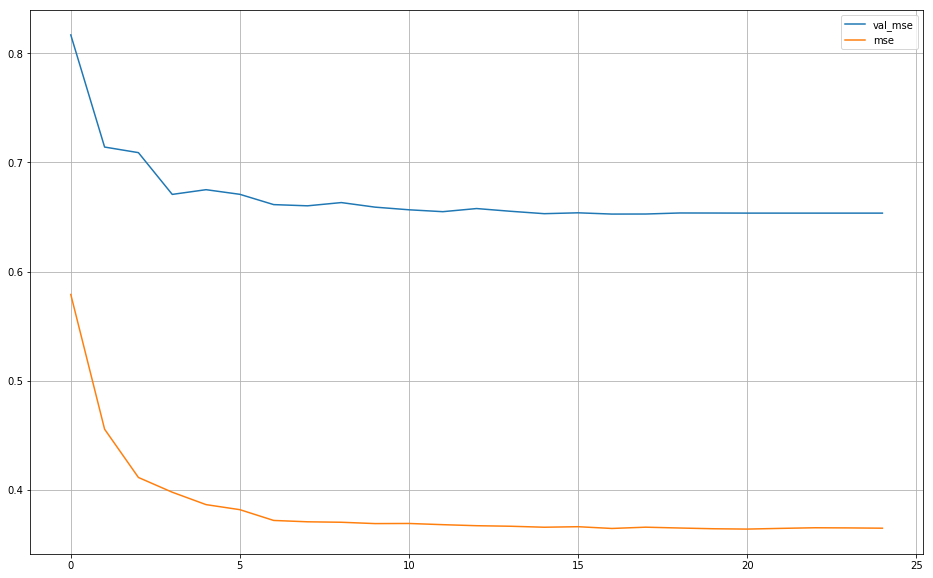

In [21]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.plot(ans['val_mse'][0], label='val_mse')
ax.plot(ans['mse'][0], label='mse')

ax.grid()
ax.legend()
plt.show()

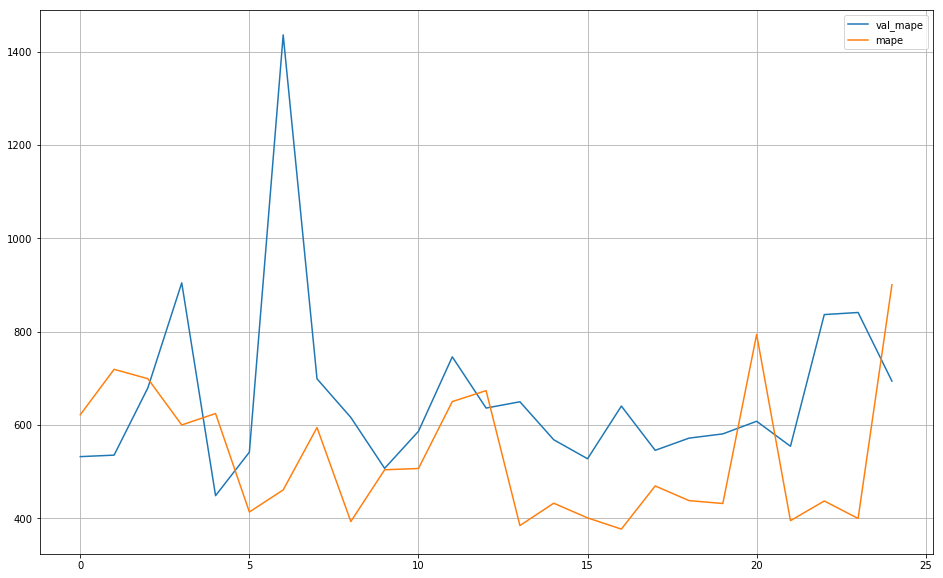

In [22]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.plot(ans['val_mape'][0], label='val_mape')
ax.plot(ans['mape'][0], label='mape')

ax.grid()
ax.legend()
plt.show()

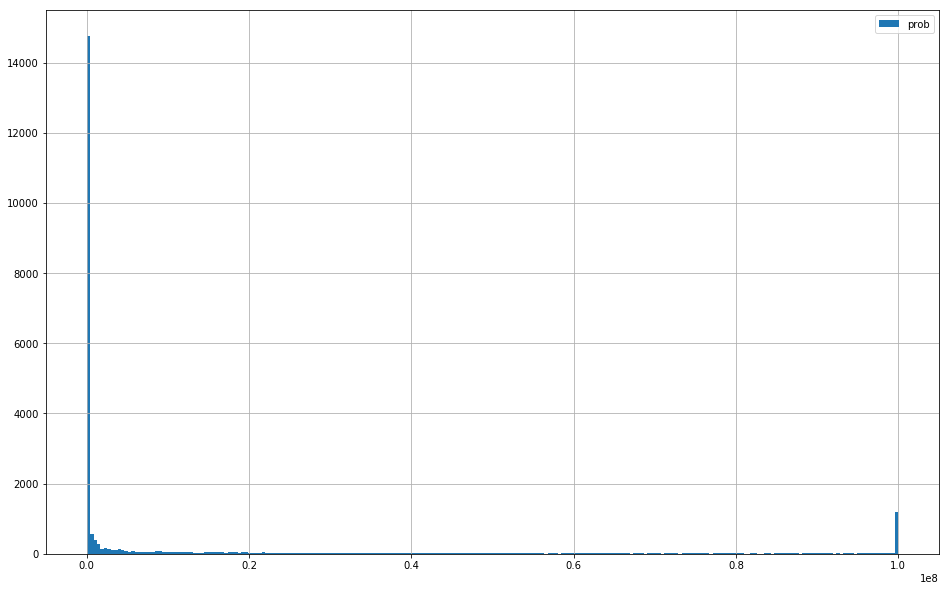

In [23]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob = scipy.stats.multivariate_normal.pdf(ans['res_test'][0], mean=ans['mean'][0], cov=ans['cov'][0])
ax.hist(np.clip(prob, 0, 1e8), label='prob', bins='auto')

ax.grid()
ax.legend()
plt.show()

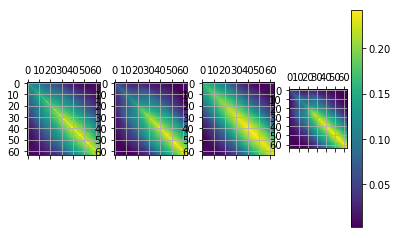

In [24]:
#convariance matrix
fig, axs = plt.subplots(ncols=len(ans['cov']))
for ax, cov in zip(axs, ans['cov']):
    cax = ax.matshow(cov)
    ax.grid()
cbar = fig.colorbar(cax)
plt.show()

In [31]:
# precision - recall - F0.1 - accuracy
met = {'run':[], 'threshold': [], 'precision': [], 'recall':[], 'F0.1-score':[], 'accuracy':[],}
for idx, (res_test, mean, cov) in enumerate(zip(ans['res_test'], ans['mean'], ans['cov'])):
    prob = scipy.stats.multivariate_normal.pdf(res_test, mean=mean, cov=cov)
    
    threshold = 0
    bestf0_1 = 0
    bestrecall = 0
    prob_sorted = np.sort(prob.copy())
    best_conf_matrix = -1
    for i in range(1000):
        p = prob_sorted[int(i/1000*len(prob_sorted))]
        y_pred = (prob < p).astype('int8')
        recall = metrics.recall_score(holidays_test, y_pred)
        f0_1 = metrics.fbeta_score(holidays_test, y_pred, beta=0.1)
        
        if recall > 0.1 and bestf0_1 < f0_1:
            bestf0_1 = f0_1
            threshold = p
    
    y_pred = (prob < threshold).astype('int8')
    print(f'idx: {idx} - threshold: {threshold} - f0_1: {bestf0_1}')
    print(metrics.classification_report(holidays_test, y_pred))
    print(f'confusion matrix:\n{metrics.confusion_matrix(holidays_test, y_pred)}')

idx: 0 - threshold: 4.406020457951977e-59 - f0_1: 0.9288612388423045
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22254
           1       1.00      0.11      0.21       594

    accuracy                           0.98     22848
   macro avg       0.99      0.56      0.60     22848
weighted avg       0.98      0.98      0.97     22848

confusion matrix:
[[22254     0]
 [  526    68]]
idx: 1 - threshold: 4.727305402232e-311 - f0_1: 0.9288612388423045
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22254
           1       1.00      0.11      0.21       594

    accuracy                           0.98     22848
   macro avg       0.99      0.56      0.60     22848
weighted avg       0.98      0.98      0.97     22848

confusion matrix:
[[22254     0]
 [  526    68]]
idx: 2 - threshold: 4.337711329623545e-223 - f0_1: 0.9288612388423045
              precision    recall  f1-scor